# Extract phases
Created 02/06/2024

Objectives:
* Extract the fermionic and proj rep group cohomologies from the solutions calculated [here](sweep_and_find_solutions.ipynb)

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain, groupby, combinations
import re

from collections import Counter, namedtuple, defaultdict

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
from jax import numpy as jnp
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import scipy

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

## Wavefunctions

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [10]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

In [12]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_non_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

## Boundary operator solutions

In [13]:
SOL_DIR = r"solutions/"

In [14]:
file_name_pattern = re.compile(r'^(?:non_)?triv_\d\.\d+_\d_\d_\d+\.pickle$')

In [15]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        print(file_name)
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    if file_name[0] == 'n':
        proj_rep=1
        b, bs, fs, i = file_name.split('_')[2:]
    elif file_name[0] == 't':
        proj_rep=0
        b, bs, fs, i = file_name.split('_')[1:]
    else:
        return None

    b = float(b)
    bs = int(bs)
    fs = int(fs)
    i = int(i)
    
    return (proj_rep, b, bs, fs, i)

In [16]:
boundary_operator_solutions = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            out = pickle.load(f)
    
            boundary_operator_solutions[key] = out

.DS_Store


### Check values

In [17]:
scores = [float(v[0]._value) for v in boundary_operator_solutions.values()]

In [18]:
pd.Series(scores).describe()

count    573.000000
mean      14.665053
std       22.783958
min        0.001833
25%        0.065218
50%        1.537037
75%       45.585068
max      216.741516
dtype: float64

In [19]:
score_pairs = defaultdict(list)

for k, v in boundary_operator_solutions.items():
    score_pairs[k[:-1]].append((k[-1], float(v[0]._value)))

In [20]:
best_score_pairs = {
    k: min(v, key=lambda x: x[1]) for k, v in score_pairs.items()
}

In [21]:
best_scores = [v[1] for v in best_score_pairs.values()]

In [22]:
len(best_score_pairs)

252

In [23]:
pd.Series(best_scores).describe()

count    252.000000
mean       1.737905
std        8.759257
min        0.001833
25%        0.018629
50%        0.053990
75%        0.203661
max       50.003654
dtype: float64

In [24]:
[k for k, v in best_score_pairs.items() if v[1]>1]

[(0, 0.5, 3, 1),
 (0, 0.5, 3, 0),
 (1, 0.5, 1, 1),
 (1, 0.5, 1, 0),
 (1, 0.5, 3, 0),
 (1, 0.5, 3, 1),
 (0, 0.5, 1, 0),
 (0, 0.5, 1, 1),
 (1, 0.5, 2, 0),
 (1, 0.5, 2, 1)]

In [25]:
best_score_pairs[(0, 0, 1, 0)]

(1, 0.017019841820001602)

In [26]:
best_boundary_operators = {
    k: boundary_operator_solutions[(*k, v[0])]
    for k, v in best_score_pairs.items()
    #if k[1] != 0.5
}

In [27]:
len(best_boundary_operators)

252

# Definitions

In [28]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [29]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [30]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [31]:
fermionic_np_symmetries = [np_I, np_JW]

In [32]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [33]:
def generate_rdm_from_tenpy_psi(mps_psi, symmetry_site_pairs,
    leftmost_symmetry_site, num_symmetry_sites, num_boundary_sites):
    
    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())
    
    q1 = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )
    
    problem_rdm = generate_problem_rdm(
        q1,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    return problem_rdm

## Optimisation functions

In [34]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo_pair.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo_pair.tag_map['right_mpo']))
    )

    return (ml, mr)

In [35]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=0):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [36]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [37]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [38]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [39]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [40]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

## Extract SPT phase functions

In [41]:
def get_right_fp_overlap(rdm, mpo_l, mpo_r, leftmost_symmetry_site,
                     num_symmetry_sites, num_boundary_sites):

    tn = rdm.copy(deep=True)

    fermionic_site_indices = [
        i
        for i in range(
            leftmost_symmetry_site+num_symmetry_sites,
            leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
        )
        if i % 2 == 1
    ]

    top_fermionic_tensors = [
        (f'k{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'k{i}'])))
        for i in fermionic_site_indices
    ]

    bottom_fermionic_tensors = [
        (f'b{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'b{i}'])))
        for i in fermionic_site_indices
    ]

    for ind, t in top_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            inplace=True
        )

    for ind, t in bottom_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            transposed=True,
            inplace=True
        )

    out = (tn & mpo_l & mpo_r) ^ ...

    return out

In [42]:
def get_left_fp_overlap(rdm, mpo_l, mpo_r, leftmost_symmetry_site,
                     num_symmetry_sites, num_boundary_sites):

    tn = rdm.copy(deep=True)

    fermionic_site_indices = [
        i
        for i in range(
            leftmost_symmetry_site-num_boundary_sites,
            leftmost_symmetry_site
        )
        if i % 2 == 1
    ]

    top_fermionic_tensors = [
        (f'k{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'k{i}'])))
        for i in fermionic_site_indices
    ]

    bottom_fermionic_tensors = [
        (f'b{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'b{i}'])))
        for i in fermionic_site_indices
    ]

    for ind, t in top_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            inplace=True
        )

    for ind, t in bottom_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            transposed=True,
            inplace=True
        )

    out = (tn & mpo_l & mpo_r) ^ ...

    return out

In [43]:
def get_fp_charges(rdm, ml, mr, left_most_symmetry_site, num_symmetry_sites,
               num_boundary_sites):
    base_overlap = (rdm & ml & mr) ^ ...

    right_fp_overlap = get_right_fp_overlap(
        rdm,
        ml,
        mr,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    left_fp_overlap = get_left_fp_overlap(
        rdm,
        ml,
        mr,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    right_fp_charge = right_fp_overlap/base_overlap
    left_fp_charge = left_fp_overlap/base_overlap

    return (left_fp_charge, right_fp_charge, base_overlap)

# Extract SPT phase
## Fermionic group cohomology

In [44]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

total_physical_dim = 2**9

In [45]:
fp_charges = dict()

for k, ops in best_boundary_operators.items():
    ml, mr = split_mpo_pair(ops[1])

    if k[0] == 0:
        tenpy_psi = loaded_data_triv_proj_rep[k[1]]
    elif k[0] == 1:
        tenpy_psi = loaded_data_non_triv_proj_rep[k[1]]

    bs = bosonic_np_symmetries[k[2]]
    fs = fermionic_np_symmetries[k[3]]

    symmetry_site_pairs = (
        [(i, bs) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
        + [(i, fs) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
    )

    rdm = generate_rdm_from_tenpy_psi(
        tenpy_psi,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    out = get_fp_charges(
        rdm,
        ml,
        mr,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    fp_charges[k] = out

In [46]:
interpolation_values = np.round(np.linspace(0,1,21), 2)

In [47]:
fp_charges_array = np.zeros((2, len(interpolation_values), 3, 2, 2), dtype='complex')

for t_nt in range(2):
    for i, t in enumerate(interpolation_values):
        for b in range(1, 4):
            for jw in range(2):
                for side in range(2):
                    charge = fp_charges[(t_nt, t, b, jw)][side]
                    fp_charges_array[t_nt, i, b-1, jw, side] = charge

In [48]:
fp_charges_array.shape

(2, 21, 3, 2, 2)

In [49]:
fp_charges_array[:, 10, ...]

array([[[[ 0.67984827+4.19238137e-01j,  0.67984827+4.19238137e-01j],
         [ 1.22916413-8.92178985e-02j,  1.22916413-8.92178985e-02j]],

        [[ 1.        -5.29388791e-16j,  1.        +1.00583870e-15j],
         [ 1.        +1.12707103e-15j,  1.        -2.81767757e-16j]],

        [[ 0.96389158+3.03012887e-02j,  0.96389158+3.03012887e-02j],
         [ 0.92295294-1.33330930e-01j,  0.92295294-1.33330930e-01j]]],


       [[[ 0.9858763 +3.41443562e-02j,  0.9858763 +3.41443562e-02j],
         [ 0.98766263-6.55575310e-02j,  0.98766263-6.55575310e-02j]],

        [[-1.02951998-4.31542719e-02j, -1.02951998-4.31542719e-02j],
         [-1.01110127-3.30056730e-02j, -1.01110127-3.30056730e-02j]],

        [[-1.        -3.40824101e-15j, -1.        -2.82397113e-15j],
         [-1.        +2.73424732e-16j, -1.        +2.18739786e-16j]]]])

Clean up data.

In [50]:
np.max(np.imag(fp_charges_array))

0.41923813696187234

In [51]:
np.all(np.abs(np.real(fp_charges_array)) == 1)

False

In [52]:
np.max(np.abs(np.abs(np.real(fp_charges_array)) - 1))

0.32015173488085524

In [53]:
np.max(np.abs(np.abs(fp_charges_array) - 1))

0.23239777729630307

In [54]:
fp_charges_array = np.real(fp_charges_array)

In [55]:
np.unique(fp_charges_array)

array([-1.02951998, -1.02951998, -1.01110127, -1.01110127, -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        ,  0.67984827,  0.67984827,
        0.92295294,  0.92295294,  0.96389158,  0.96389158,  0.9858763 ,
        0.9858763 ,  0.98766263,  0.98766263,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [56]:
np.all(np.abs(fp_charges_array) == 1)

False

In [58]:
fp_n1_array = (-1j/np.pi)*(np.emath.log(fp_charges_array + 0*1j))

In [59]:
fp_n1_array.shape

(2, 21, 3, 2, 2)

In [60]:
np.max(np.abs(np.abs(fp_charges_array)-1))

0.32015173488085524

In [61]:
fp_charges_array = np.round(fp_charges_array, 0).astype('int')

In [62]:
np.unique(fp_charges_array)

array([-1,  1])

In [63]:
np.all(fp_charges_array[...,0] == fp_charges_array[...,1])

True

In [64]:
fp_charges_array = fp_charges_array[...,0]

In [65]:
np.all(fp_charges_array[...,0] == fp_charges_array[...,1])

True

In [66]:
fp_charges_array = fp_charges_array[...,0]

In [67]:
fp_charges_array.shape

(2, 21, 3)

In [68]:
fp_charges_array[0]

array([[-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1]])

In [69]:
fp_charges_array[1, :]

array([[ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1]])

In [70]:
interpolation_values.shape

(21,)

In [71]:
fp_charges_array

array([[[-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1]]])

In [73]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [74]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

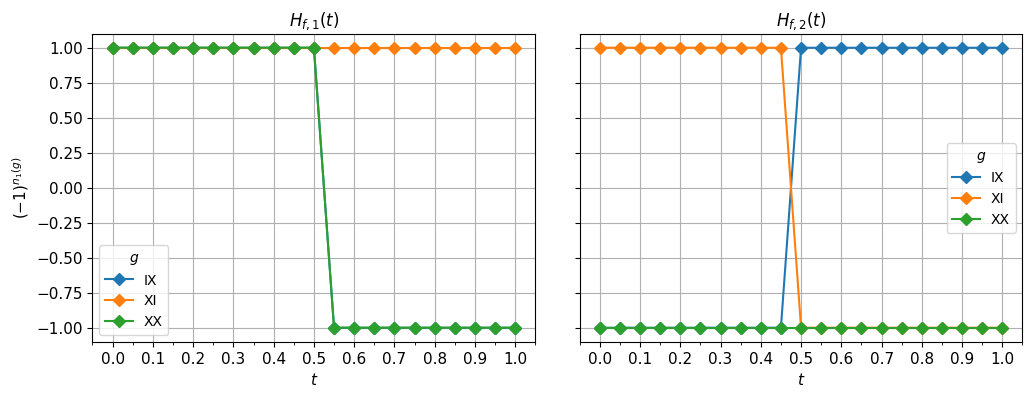

In [76]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    ax1.plot(
        interpolation_values[::-1],
        fp_charges_array[0, :, j],
        color=col,
        label = label,
        marker='D'
    )

    ax2.plot(
        interpolation_values[::-1],
        fp_charges_array[1, :, j],
        color=col,
        label = label,
        marker='D'
    )

for k, ax in enumerate([ax1, ax2]):
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )
    
    
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    ax.set_ylabel(r'$(-1)^{n_1(g)}$', fontsize=11)
    ax.set_xlabel('$t$', fontsize=11)

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax1.legend(loc='lower left', title='$g$')
ax2.legend(loc='center right', title='$g$')

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)

fig.savefig(r'plots/n1_phase_fermionic_mpo.png', dpi=200)

In [77]:
scores_array = np.zeros((2, len(interpolation_values), 3, 2), dtype='complex')

for t_nt in range(2):
    for i, t in enumerate(interpolation_values):
        for b in range(1, 4):
            for jw in range(2):
                score = fp_charges[(t_nt, t, b, jw)][2]
                scores_array[t_nt, i, b-1, jw] = score

In [78]:
pd.Series(np.abs(scores_array.flatten())).describe()

count    2.520000e+02
mean     9.414950e-01
std      1.727435e-01
min      4.989135e-10
25%      9.531972e-01
50%      9.816003e-01
75%      9.914326e-01
max      1.002534e+00
dtype: float64

In [79]:
scores_array.shape

(2, 21, 3, 2)

In [80]:
np.max(scores_array)

(0.9972302804970552+0.04317248120250161j)

In [81]:
np.max(
    np.delete(
        np.abs(
            np.abs(scores_array[...,0])
            - np.abs(scores_array[...,1])
        )
        ,
        10,
        axis=1
    )
)

0.0832278968530411

In [82]:
single_fp_charges = {k: np.real(np.round(v[0], 2)) for k, v in fp_charges.items()}

In [83]:
g = groupby(single_fp_charges.items(), key=lambda x: x[0][:-1])
single_fp_charges_deduplicated = dict()

for k, v in g:
    if k[1] != 0.5:
        values = [v1[1] for v1 in v]
        assert len(Counter(values)) == 1
        single_fp_charges_deduplicated[k] = values[0]

In [84]:
single_fp_charges_deduplicated

{(0, 0.9, 3): 1.0,
 (1, 0.35, 2): -1.0,
 (0, 0.45, 1): -1.0,
 (1, 0.25, 1): 1.0,
 (1, 0.4, 3): -1.0,
 (1, 0.05, 2): -1.0,
 (0, 0.45, 3): -1.0,
 (1, 0.15, 1): 1.0,
 (1, 0.3, 3): -1.0,
 (1, 0.35, 3): -1.0,
 (1, 0.65, 1): -1.0,
 (1, 0.75, 2): 1.0,
 (1, 0.4, 2): -1.0,
 (1, 0.55, 1): -1.0,
 (1, 0.45, 2): -1.0,
 (1, 0.3, 2): -1.0,
 (0, 0.7, 2): 1.0,
 (0, 0.0, 2): 1.0,
 (0, 0.25, 3): -1.0,
 (1, 0.45, 1): 1.0,
 (1, 0.1, 3): -1.0,
 (1, 0.55, 2): 1.0,
 (1, 0.4, 1): 1.0,
 (0, 0.65, 3): 1.0,
 (1, 0.25, 2): -1.0,
 (0, 0.2, 1): -1.0,
 (1, 0.2, 3): -1.0,
 (1, 0.35, 1): 1.0,
 (1, 0.8, 1): -1.0,
 (0, 0.85, 1): 1.0,
 (0, 0.15, 3): -1.0,
 (0, 0.95, 2): 1.0,
 (1, 0.2, 2): -1.0,
 (1, 0.1, 2): -1.0,
 (0, 1.0, 2): 1.0,
 (0, 0.8, 3): 1.0,
 (1, 0.15, 2): -1.0,
 (0, 0.55, 3): 1.0,
 (1, 0.0, 1): 1.0,
 (1, 0.45, 3): -1.0,
 (1, 0.85, 3): -1.0,
 (0, 0.4, 1): -1.0,
 (0, 0.3, 1): -1.0,
 (1, 0.9, 1): -1.0,
 (0, 0.1, 2): 1.0,
 (0, 0.6, 2): 1.0,
 (1, 0.05, 3): -1.0,
 (1, 0.0, 3): -1.0,
 (1, 0.65, 3): -1.0,
 (1, 0.6, 2):

Pull out correct cases.

In [85]:
signs_to_01 = {1.0: 0, -1.0: 1}

In [86]:
correct_boundary_operators = {
    k: best_boundary_operators[(*k, signs_to_01[v])][1]
    for k, v in single_fp_charges_deduplicated.items()
}

In [87]:
len(correct_boundary_operators)

120

In [88]:
correct_boundary_operators

{(0, 0.9, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.35, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (0, 0.45, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.25, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.4, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.05, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (0, 0.45, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.15, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.3, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.35, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.65, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.75, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.4, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.55, 1): TensorNetwork1D(tensors=12, indices=34, 

## Check scores of untaries

In [89]:
test_tn = list(correct_boundary_operators.values())[0]

In [90]:
total_physical_dim = 2**9

In [91]:
ml, mr = split_mpo_pair(test_tn)

In [92]:
unitarity_tn(ml, total_physical_dim)

Array(0.01184082, dtype=float32, weak_type=True)

In [93]:
unitarity_tn(mr, total_physical_dim)

Array(0.00653076, dtype=float32, weak_type=True)

Compute overlap.

In [94]:
correct_boundary_operators_scores = dict()

for k, tn in correct_boundary_operators.items():
    ml, mr = split_mpo_pair(tn)

    if k[0] == 0:
        tenpy_psi = loaded_data_triv_proj_rep[k[1]]
    elif k[0] == 1:
        tenpy_psi = loaded_data_non_triv_proj_rep[k[1]]

    bs = bosonic_np_symmetries[k[2]]
    fs_key = signs_to_01[single_fp_charges_deduplicated[k]]
    fs = fermionic_np_symmetries[fs_key]

    symmetry_site_pairs = (
        [(i, bs) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
        + [(i, fs) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
    )

    rdm = generate_rdm_from_tenpy_psi(
        tenpy_psi,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    left_unitarity_score = unitarity_tn(ml, total_physical_dim)
    right_unitarity_score = unitarity_tn(mr, total_physical_dim)
    overlap = np.abs((rdm & ml & mr) ^ ...)

    correct_boundary_operators_scores[k] = (
        left_unitarity_score,
        right_unitarity_score,
        overlap
    )

In [95]:
correct_boundary_operators_scores[(1, 0, 1)]

(Array(0.04418945, dtype=float32, weak_type=True),
 Array(0.03625488, dtype=float32, weak_type=True),
 0.9168725847831561)

In [96]:
correct_boundary_operators_scores[(1, 0, 2)]

(Array(0.00320435, dtype=float32, weak_type=True),
 Array(0.01879883, dtype=float32, weak_type=True),
 0.9834314141085325)

In [97]:
correct_boundary_operators_scores[(1, 0, 3)]

(Array(0.00866699, dtype=float32, weak_type=True),
 Array(0.00805664, dtype=float32, weak_type=True),
 0.9845429562477903)

In [98]:
correct_boundary_operators_scores[(1, 0.05, 1)]

(Array(0.01873779, dtype=float32, weak_type=True),
 Array(0.01538086, dtype=float32, weak_type=True),
 0.9634160489625682)

In [99]:
correct_boundary_operators_scores[(1, 0.05, 2)]

(Array(0.01452637, dtype=float32, weak_type=True),
 Array(0.00708008, dtype=float32, weak_type=True),
 0.9700430399144698)

In [100]:
correct_boundary_operators_scores[(1, 0.05, 3)]

(Array(0.01501465, dtype=float32, weak_type=True),
 Array(0.01123047, dtype=float32, weak_type=True),
 0.9735226181196421)

In [101]:
correct_scores = {
    k: best_score_pairs[(*k, signs_to_01[v])][1]
    for k, v in single_fp_charges_deduplicated.items()
}

In [102]:
interpolation_values = np.round(np.linspace(0, 1, 21), 2)
interpolation_values = np.delete(interpolation_values, 10, axis=0)

In [103]:
correct_scores_array = np.zeros((2, len(interpolation_values), 3))

for i in range(2):
    for j, t in enumerate(interpolation_values):
        for b in range(1, 4):
            correct_scores_array[i, j, b-1] = correct_scores[(i, t, b)]

In [104]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [105]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [106]:
e, a, b, c = symmetry_labels

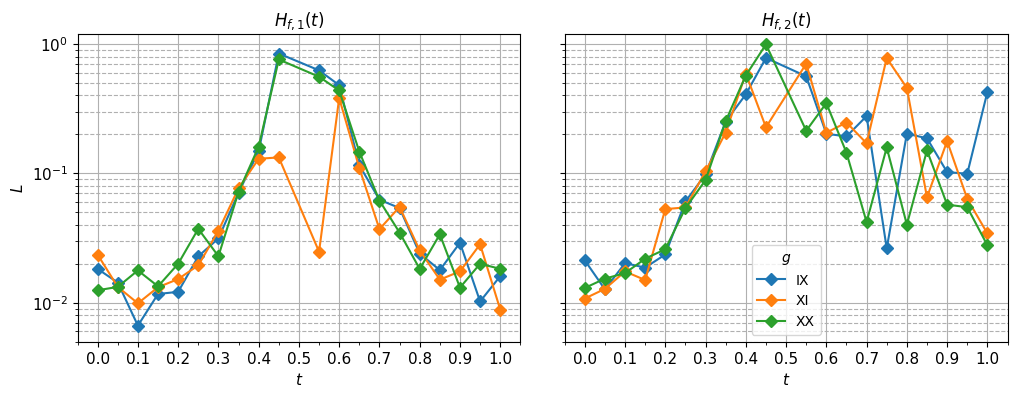

In [107]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
        ax.plot(
            1-interpolation_values, # I ordered this wrong at definition
            correct_scores_array[k, :, j],
            color=col,
            label=label,
            marker='D'
        )

    ax.set_ylim(5e-3, 1.2)
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )
    
    ax.set_yscale('log')

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    if k == 0:
        ax.set_ylabel(r'$L$', fontsize=11)
    ax.set_xlabel('$t$', fontsize=11)

    if k == 1:
        ax.legend(loc='lower center', title='$g$')

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)
    
fig.savefig(r'plots/cost_function_from_mpo_fermionic.png', dpi=200)

## Proj rep group cohomology

### Group data definitions

In [108]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [109]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [110]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [111]:
e, a, b, c = symmetry_labels

In [112]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

### Evaluate

In [113]:
def tensor_network_to_mpo(tn):
    sites = [
        int(s[1:]) for s in tn.tag_map
        if s[0]=='I'
    ]
    
    rho = qtn.MatrixProductOperator(
        [t.data for t in tn.tensors],
        sites=sites
    )

    return rho

In [114]:
def mpo_hermitian_conjugate(quimb_mpo):
    t = quimb_mpo.copy().conj()
    relabel_mpo(t, 'b', 'k')

    return t

In [115]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    t = (
        rho
        ._apply_mpo(u_h, compress=False, contract=False)
        ._apply_mpo(u_g, compress=False, contract=False)
        ._apply_mpo(mpo_hermitian_conjugate(u_gh), compress=False, contract=False)
    )

    out = t.trace()

    return (out/(np.abs(out)), np.abs(out))

In [116]:
def get_quimb_mps_from_tenpy_mps(tenpy_mps):
    psi_arrays = list()
    psi_arrays.append(tenpy_mps.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, tenpy_mps.L-1):
        psi_arrays.append(tenpy_mps.get_B(i).to_ndarray())
    psi_arrays.append(tenpy_mps.get_B(tenpy_mps.L-1)[..., 0].to_ndarray())
    
    quimb_mps = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    return quimb_mps

In [117]:
def get_proj_rep_phases(tenpy_mps, unitaries):
    quimb_mps = get_quimb_mps_from_tenpy_mps(tenpy_mps)
    sites = [
        int(s[1:]) for s in unitaries[0].tag_map
        if s[0]=='I'
    ]
    rho = quimb_mps.partial_trace_to_mpo(sites, rescale_sites=False)
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

In [118]:
interpolation_values = np.delete(np.round(np.linspace(0, 1, 21), 3), 10)

In [119]:
interpolation_values

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [120]:
triv_proj_rep_phases = list()

for t in interpolation_values:
    tenpy_mps = loaded_data_triv_proj_rep[t]

    unitaries = [correct_boundary_operators[(0, t, i)] for i in [1,2,3]]

    unitary_pairs = [split_mpo_pair(p) for p in unitaries]
    mpo_pairs = [(tensor_network_to_mpo(x), tensor_network_to_mpo(y)) for x,y in unitary_pairs]
    left_unitaries, right_unitaries = zip(*mpo_pairs)

    left_phases = get_proj_rep_phases(tenpy_mps, left_unitaries)
    right_phases = get_proj_rep_phases(tenpy_mps, right_unitaries)

    triv_proj_rep_phases.append([left_phases, right_phases])

In [121]:
triv_proj_rep_phases = np.array(triv_proj_rep_phases)

In [122]:
triv_proj_rep_phases.shape

(20, 2, 6, 2)

In [123]:
np.round(
    triv_proj_rep_phases[..., ::2, 0]/triv_proj_rep_phases[..., 1::2, 0],
    2
)

array([[[1.-0.j  , 1.+0.j  , 1.+0.j  ],
        [1.+0.j  , 1.+0.j  , 1.-0.j  ]],

       [[1.+0.j  , 1.-0.j  , 1.+0.j  ],
        [1.-0.j  , 1.-0.j  , 1.-0.j  ]],

       [[1.+0.j  , 1.+0.j  , 1.-0.j  ],
        [1.+0.j  , 1.-0.j  , 1.-0.j  ]],

       [[1.-0.j  , 1.+0.j  , 1.+0.j  ],
        [1.+0.01j, 1.+0.01j, 1.+0.j  ]],

       [[1.-0.j  , 1.-0.j  , 1.-0.j  ],
        [1.+0.j  , 1.-0.j  , 1.+0.j  ]],

       [[1.+0.j  , 1.-0.j  , 1.+0.j  ],
        [1.+0.j  , 1.-0.j  , 1.+0.j  ]],

       [[1.-0.j  , 1.-0.j  , 1.+0.j  ],
        [1.-0.j  , 1.+0.j  , 1.+0.j  ]],

       [[1.+0.j  , 1.+0.j  , 1.-0.j  ],
        [1.-0.j  , 1.+0.02j, 1.+0.j  ]],

       [[1.+0.01j, 1.-0.j  , 1.+0.01j],
        [1.-0.01j, 1.+0.j  , 1.+0.j  ]],

       [[1.+0.j  , 1.+0.j  , 1.+0.j  ],
        [1.-0.j  , 1.-0.j  , 1.-0.j  ]],

       [[1.+0.01j, 1.-0.03j, 1.+0.04j],
        [1.+0.j  , 1.+0.04j, 1.+0.01j]],

       [[1.-0.j  , 1.+0.j  , 1.-0.01j],
        [1.-0.02j, 1.-0.03j, 1.-0.01j]],

       [[1.-0.j 

In [124]:
triv_gauge_invariant_proj_rep_phase = triv_proj_rep_phases[..., ::2, 0]/triv_proj_rep_phases[..., 1::2, 0]

In [125]:
triv_delta_gauge_invariant_proj_rep_phase = triv_gauge_invariant_proj_rep_phase.copy()
#triv_delta_gauge_invariant_proj_rep_phase[:10]*=-1

In [126]:
triv_delta_gauge_invariant_proj_rep_angle = np.imag(np.log(triv_delta_gauge_invariant_proj_rep_phase))

In [127]:
triv_delta_gauge_invariant_proj_rep_angle.shape

(20, 2, 3)

In [128]:
non_triv_proj_rep_phases = list()

for t in interpolation_values:
    tenpy_mps = loaded_data_non_triv_proj_rep[t]

    unitaries = [correct_boundary_operators[(1, t, i)] for i in [1,2,3]]

    unitary_pairs = [split_mpo_pair(p) for p in unitaries]
    mpo_pairs = [(tensor_network_to_mpo(x), tensor_network_to_mpo(y)) for x,y in unitary_pairs]
    left_unitaries, right_unitaries = zip(*mpo_pairs)

    left_phases = get_proj_rep_phases(tenpy_mps, left_unitaries)
    right_phases = get_proj_rep_phases(tenpy_mps, right_unitaries)

    non_triv_proj_rep_phases.append([left_phases, right_phases])

In [129]:
non_triv_proj_rep_phases = np.array(non_triv_proj_rep_phases)

In [130]:
non_triv_proj_rep_phases.shape

(20, 2, 6, 2)

In [131]:
np.round(
    non_triv_proj_rep_phases[..., ::2, 0]/non_triv_proj_rep_phases[..., 1::2, 0],
    2
)

array([[[-1.+0.j  , -1.-0.j  , -1.-0.j  ],
        [-1.-0.j  , -1.+0.j  , -1.-0.j  ]],

       [[-1.+0.j  , -1.+0.j  , -1.+0.j  ],
        [-1.+0.j  , -1.-0.j  , -1.-0.j  ]],

       [[-1.-0.j  , -1.-0.j  , -1.+0.j  ],
        [-1.-0.j  , -1.+0.j  , -1.+0.j  ]],

       [[-1.+0.01j, -1.-0.j  , -1.-0.01j],
        [-1.+0.j  , -1.-0.j  , -1.+0.j  ]],

       [[-1.-0.j  , -1.+0.j  , -1.+0.j  ],
        [-1.-0.03j, -1.+0.01j, -1.-0.j  ]],

       [[-1.-0.01j, -1.+0.01j, -1.-0.01j],
        [-1.-0.j  , -1.-0.j  , -1.-0.j  ]],

       [[-1.+0.j  , -1.-0.j  , -1.-0.j  ],
        [-1.-0.j  , -1.+0.j  , -1.-0.j  ]],

       [[-1.+0.02j, -1.-0.01j, -1.-0.j  ],
        [-1.+0.j  , -1.-0.j  , -1.-0.j  ]],

       [[-1.-0.01j, -1.-0.02j, -1.+0.02j],
        [-1.+0.01j, -1.-0.01j, -1.+0.j  ]],

       [[-1.-0.03j, -1.-0.01j, -1.-0.j  ],
        [-1.+0.02j, -1.-0.j  , -1.-0.j  ]],

       [[ 1.+0.01j,  1.-0.j  ,  1.+0.01j],
        [ 1.+0.j  ,  1.+0.01j,  1.+0.j  ]],

       [[ 1.-0.01j,  1.-0.01j,  

In [132]:
non_triv_gauge_invariant_proj_rep_phase = non_triv_proj_rep_phases[..., ::2, 0]/non_triv_proj_rep_phases[..., 1::2, 0]

In [133]:
non_triv_delta_gauge_invariant_proj_rep_phase = non_triv_gauge_invariant_proj_rep_phase.copy()
non_triv_delta_gauge_invariant_proj_rep_phase[:10]*=-1

In [134]:
non_triv_delta_gauge_invariant_proj_rep_angle = np.imag(np.log(non_triv_delta_gauge_invariant_proj_rep_phase))

In [135]:
non_triv_delta_gauge_invariant_proj_rep_angle.shape

(20, 2, 3)

In [136]:
delta_gauge_invariant_proj_rep_angle = np.stack(
    [triv_delta_gauge_invariant_proj_rep_angle, non_triv_delta_gauge_invariant_proj_rep_angle],
    axis=0
)

In [137]:
markers = ['<', '>']

In [138]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [139]:
e, a, b, c = symmetry_labels

In [140]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [141]:
side_labels = ['Left', 'Right']

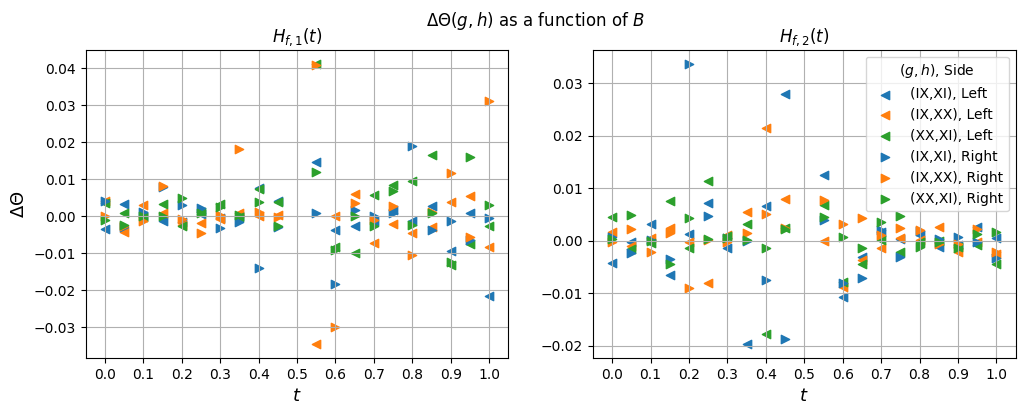

In [142]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    for i, (marker, side_label) in enumerate(zip(markers, side_labels)):
        for j, (col, label) in enumerate(zip(colors, symmetry_pair_labels)):
            ax.scatter(
                interpolation_values,
                delta_gauge_invariant_proj_rep_angle[k, :, i, j],
                marker=marker,
                color=col,
                label = f'({label}), {side_label}'
            )
    
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    
    ax.grid()
    if k == 0:
        ax.set_ylabel(r'$\Delta \Theta$', fontsize=13)
    ax.set_xlabel('$t$', fontsize=13)

    if k == 1:
        ax.legend(loc='upper right', title='$(g,h)$, Side')

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')

fig.suptitle(r'$\Delta \Theta(g,h)$ as a function of $B$')

fig.savefig(r'plots/delta_proj_rep_angle_from_mpo_fermionc.png', dpi=200)

In [143]:
gauge_invariant_proj_rep_phase = np.stack(
    [triv_gauge_invariant_proj_rep_phase, non_triv_gauge_invariant_proj_rep_phase],
    axis=0
)

In [144]:
gauge_invariant_proj_rep_phase.shape

(2, 20, 2, 3)

In [145]:
gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phase))
gauge_invariant_proj_rep_angle[gauge_invariant_proj_rep_angle<=-np.pi/2] += 2*np.pi

In [146]:
gauge_invariant_proj_rep_angle.shape

(2, 20, 2, 3)

In [147]:
mean_gauge_invariant_proj_rep_angle = np.mean(gauge_invariant_proj_rep_angle, axis=(2,3))
max_gauge_invariant_proj_rep_angle = np.max(gauge_invariant_proj_rep_angle, axis=(2,3))
min_gauge_invariant_proj_rep_angle = np.min(gauge_invariant_proj_rep_angle, axis=(2,3))

min_max_gauge_invariant_proj_rep_angle = np.stack(
    [
        min_gauge_invariant_proj_rep_angle,
        max_gauge_invariant_proj_rep_angle
    ],
    axis=0
)

error_gauge_invariant_proj_rep_angle = (
    min_max_gauge_invariant_proj_rep_angle
    - mean_gauge_invariant_proj_rep_angle[np.newaxis, :]
)
error_gauge_invariant_proj_rep_angle = np.abs(error_gauge_invariant_proj_rep_angle)

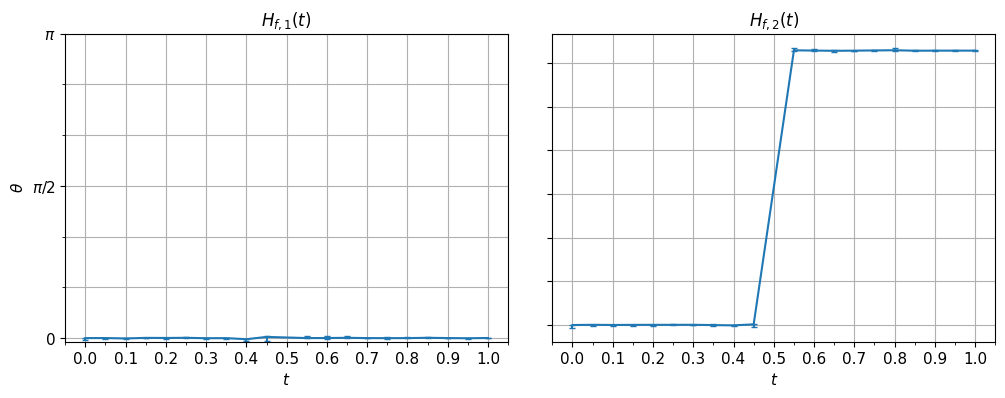

In [148]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    ax.errorbar(
        interpolation_values[::-1],
        mean_gauge_invariant_proj_rep_angle[k],
        yerr=error_gauge_invariant_proj_rep_angle[k],
        color='tab:blue',
        fmt='-',
        capsize=2
    )

    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )

    ax.grid(
        axis='y',
        which='both'
    )
    ax.grid(
        axis='x',
        which='major'
    )

    ax.set_xlabel('$t$', fontsize=11)

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax1.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax1.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)

ax1.set_ylabel(r'$\theta$', fontsize=11)

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)

fig.savefig(r'plots/proj_rep_angle_from_mpo_fermionic.png', dpi=200)

# Plot overlaps

In [149]:
np.mean(np.array([
    l
    for t in correct_boundary_operators_scores.values()
    for l in t[:2]
]))

0.041232172

In [150]:
np.max(np.array([
    l
    for t in correct_boundary_operators_scores.values()
    for l in t[:2]
]))

0.37902832

In [151]:
correct_overlaps_array = np.zeros((2, len(interpolation_values), 3))

for i in range(2):
    for j, t in enumerate(interpolation_values):
        for b in range(1, 4):
            correct_overlaps_array[i, j, b-1] = correct_boundary_operators_scores[(i, t, b)][2]

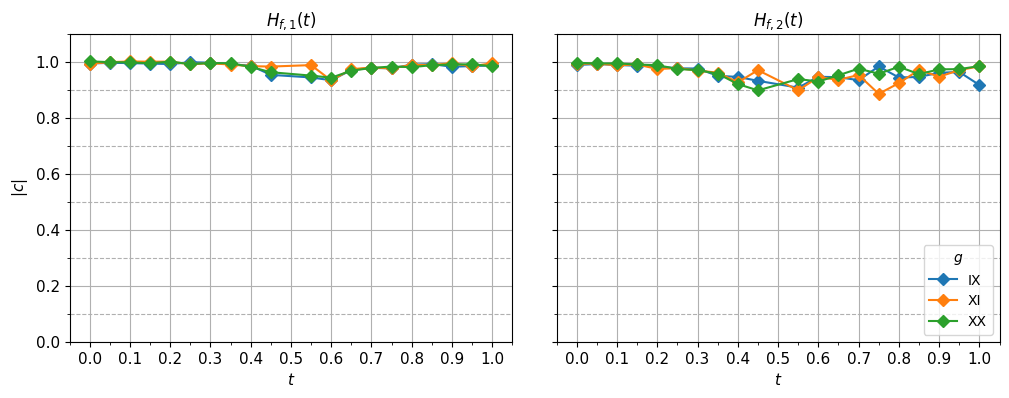

In [152]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
        ax.plot(
            1-interpolation_values, # I ordered this wrong at definition
            correct_overlaps_array[k, :, j],
            color=col,
            label=label,
            marker='D'
        )

    ax.set_ylim(0, 1.1)
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )
    ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    if k == 0:
        ax.set_ylabel(r'$\vert c \vert$', fontsize=11)
    ax.set_xlabel('$t$', fontsize=11)

    if k == 1:
        ax.legend(loc='lower right', title='$g$')

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)
    
fig.savefig(r'plots/overlap_from_mpo_fermionic.png', dpi=200)

# Combine plots

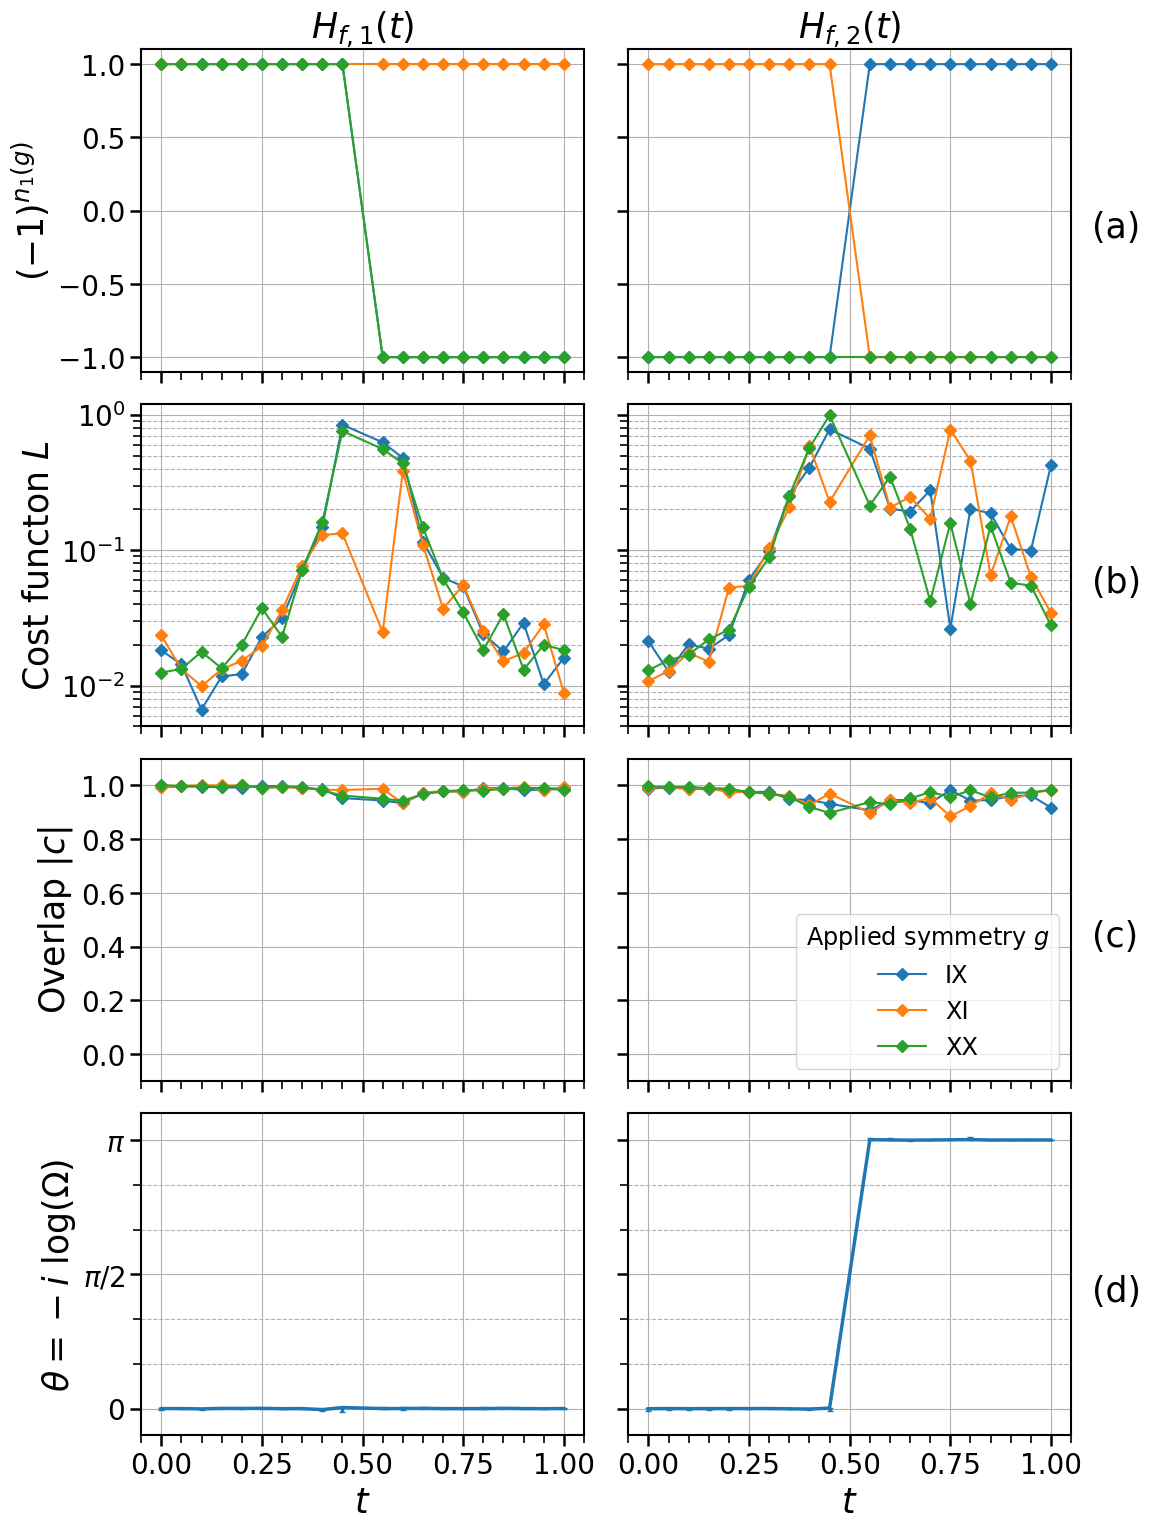

In [171]:
figure_label_fontsize=25
y_tick_label_fontsize=20
y_label_fontsize=25
x_tick_label_fontsize=20
x_label_fontsize=25
row_label_fontsize=25

axis_spine_linewidth = 1.5

major_tick_length = 8
major_tick_width = 1.8
minor_tick_length = 6
minor_tick_width = 1.2

phase_linewidth = 2.5

fig, ax_grid = plt.subplots(figsize=(12, 18), ncols=2, nrows=4)

top_three_data = [
    np.delete(fp_charges_array, 10, axis=1),
    correct_scores_array,
    correct_overlaps_array
]

for ax_row, data in zip(ax_grid[:3], top_three_data):
    for k, ax in enumerate(ax_row):
        for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
            ax.plot(
                1-interpolation_values, # I ordered this wrong at definition
                data[k, :, j],
                color=col,
                label=label,
                marker='D'
            )

for k, ax in enumerate(ax_grid[-1]):
    ax.errorbar(
        interpolation_values[::-1],
        mean_gauge_invariant_proj_rep_angle[k],
        yerr=error_gauge_invariant_proj_rep_angle[k],
        color='tab:blue',
        fmt='-',
        capsize=2,
        linewidth=phase_linewidth
    )

ax_grid[0][0].set_ylim(-1.1, 1.1)
ax_grid[0][1].set_ylim(-1.1, 1.1)
ax_grid[1][0].set_ylim(5e-3, 1.2)
ax_grid[1][1].set_ylim(5e-3, 1.2)

ax_grid[1][0].set_yscale('log')
ax_grid[1][1].set_yscale('log')

ax_grid[2][0].set_ylim(-0.1, 1.1)
ax_grid[2][1].set_ylim(-0.1, 1.1)
ax_grid[3][0].set_ylim((-0.1)*np.pi, np.pi*(1.1))
ax_grid[3][1].set_ylim((-0.1)*np.pi, np.pi*(1.1))

for i, row in enumerate(ax_grid):
    for j, ax in enumerate(row):
        ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.25)
        )
        ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.05)
        )
        ax.grid()

        ax.grid(
            which='minor',
            axis='y',
            linestyle='--',
            zorder=-1e10
        )

        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(axis_spine_linewidth)

        ax.tick_params(
            axis='both',
            which='major',
            length=major_tick_length,
            width=major_tick_width
        )

        ax.tick_params(
            axis='both',
            which='minor',
            length=minor_tick_length,
            width=minor_tick_width
        )

        if i==2:
            ax.yaxis.set_major_locator(
                matplotlib.ticker.MultipleLocator(0.2)
            )

        if i == 3:
            ax.set_yticks(
                np.linspace(0, np.pi, 3),
                labels=['$0$', '$\pi/2$', '$\pi$']
            )
            
            ax.set_yticks(
                [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
                minor=True
            )

            ax.set_xlabel('$t$', fontsize=x_label_fontsize)

            ax.tick_params(
                axis='x',
                which='major',
                labelsize=x_tick_label_fontsize
            )

        if i == 0:
            ax.title.set_text(rf'$H_{{f,{j+1}}}(t)$')
            ax.title.set_fontsize(figure_label_fontsize)

            ax.yaxis.set_major_locator(
                matplotlib.ticker.MultipleLocator(0.5)
            )

        if j == 0:
            ax.tick_params(
                axis='y',
                which='major',
                labelsize=y_tick_label_fontsize
            )
        if j == 1:
            ax.set_yticklabels([])
            ax.yaxis.set_label_position("right")
        if i!= 3:
            ax.set_xticklabels([])

ax_grid[0][0].set_ylabel(r'$(-1)^{n_1(g)}$', fontsize=y_label_fontsize)
ax_grid[1][0].set_ylabel(r'Cost functon $L$', fontsize=y_label_fontsize)
ax_grid[2][0].set_ylabel(r'Overlap $\vert c \vert$', fontsize=y_label_fontsize)
ax_grid[3][0].set_ylabel(r'$\theta=-i\ \log(\Omega)$', fontsize=y_label_fontsize)

for i, l in enumerate('abcd'):
    ax_grid[i][1].set_ylabel(
        f'({l})',
        fontsize=y_label_fontsize,
        rotation='horizontal',
        ha='left',
        labelpad=15
    )

ax_grid[2][1].legend(
    loc='lower right',
    title='Applied symmetry $g$',
    fontsize='xx-large',
    title_fontsize='xx-large'
)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

fig.savefig(
    r'plots/mpo_fermionic_results.png',
    dpi=200,
    bbox_inches='tight'
)

# Conclusion
It's working!